In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from useful_functions import remove_zeros, remove_before, import_file, make_bins, make_equal_bins
from new_useful_functions import preprocess

In [24]:
loc_b53 = pd.read_excel('Data/Nieuw/2.P01.xlsx')
loc_b53 = preprocess('Data/Nieuw/2.P01.xlsx')
print(loc_b53)


                   Date  Count
24  2024-06-12 08:10:15    0.0
25  2024-06-12 08:16:40    3.0
26  2024-06-12 08:21:40  153.0
27  2024-06-12 08:26:40    0.0
28  2024-06-12 08:31:40    0.0
..                  ...    ...
200 2024-06-12 23:41:52    0.0
201 2024-06-12 23:46:52    0.0
202 2024-06-12 23:47:50    2.0
203 2024-06-12 23:52:50   14.0
204 2024-06-12 23:57:50    0.0

[181 rows x 2 columns]


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from io import BytesIO

def predict_occupancy_session(file_name, date):
    loc_b53 = pd.read_excel(file_name)
    # Load the data from CSV (replace 'path_to_your_data.csv' with your actual file path)
    data = loc_b53

    # Convert the 'Date' column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Sort data by date in case it's not sorted
    data = data.sort_values('Date')

    # Initialize variables
    session_id = 0
    in_session = False
    session_labels = []

    # Iterate over the data to identify sessions
    for i in range(len(data)):
        if data['Count'].iloc[i] > 0 and not in_session:
            # Start a new session
            in_session = True
            session_id += 1

        if in_session:
            session_labels.append(session_id)
        else:
            session_labels.append(0)

        if in_session and data['Count'].iloc[i] < 5:
            in_session = False

    # Add session labels to the dataframe
    data['Session'] = session_labels

    # Remove sessions with fewer than 6 data points
    session_counts = data['Session'].value_counts()
    valid_sessions = session_counts[session_counts >= 6].index
    data.loc[~data['Session'].isin(valid_sessions), 'Session'] = 0

    # Function to remove outliers and calculate average
    def remove_outliers_and_calculate_avg(counts):
        q1 = counts.quantile(0.25)
        q3 = counts.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_counts = counts[(counts >= lower_bound) & (counts <= upper_bound)]
        return filtered_counts.mean()

    # Function to determine the number of people based on the average count
    def determine_people(avg_count):
        # Linear relationship: 250 -> 4 people, 125 -> 2 people
        people = avg_count / 62.5  # 250/4 = 62.5
        return round(people)

    # Function to split sessions based on changes in rolling average
    def split_sessions_based_on_changes(data, window=5, change_threshold=50):
        new_session_id = max(data['Session']) + 1
        for session in data['Session'].unique():
            if session == 0:
                continue
            session_data = data[data['Session'] == session]
            if len(session_data) < 1:
                continue

            rolling_avg = session_data['Count'].rolling(window=window, min_periods=2).mean()
            session_data = session_data.copy()
            session_data['Rolling_Avg'] = rolling_avg

            prev_avg = rolling_avg.iloc[0]
            for i in range(1, len(session_data)):
                current_avg = rolling_avg.iloc[i]
                if abs(current_avg - prev_avg) > change_threshold:
                    data.loc[session_data.index[i:], 'Session'] = new_session_id
                    new_session_id += 1
                    break
                prev_avg = current_avg

    # Split sessions based on changes in rolling average
    split_sessions_based_on_changes(data)

    # Remove sessions with fewer than 6 data points after splitting
    session_counts = data['Session'].value_counts()
    valid_sessions = session_counts[session_counts >= 6].index
    data.loc[~data['Session'].isin(valid_sessions), 'Session'] = 0

    # Function to plot data for a specific day
    def plot_day(data, date):
        # Filter data for the specified day
        start_date = datetime.strptime(date, '%Y-%m-%d')
        end_date = start_date + timedelta(days=1)
        day_data = data[(data['Date'] >= start_date) & (data['Date'] < end_date)]

        # Plot the original data line
        plt.figure(figsize=(15, 7))
        plt.plot(np.array(day_data['Date']), np.array(day_data['Count']), label='Original Count', color='black', linewidth=1, alpha=0.5)

        # Overlay the session data
        unique_sessions = day_data['Session'].unique()

        for session in unique_sessions[1:]:
            session_data = day_data[day_data['Session'] == session]
            volume = len(session_data)
            avg_count = remove_outliers_and_calculate_avg(session_data['Count'])
            people = determine_people(avg_count)
            label = f'Session {session}: {people} people, Volume={volume}, Avg Count={avg_count:.2f}'
            color = None  # Let matplotlib choose the color

            plt.plot(np.array(session_data['Date']), np.array(session_data['Count']), label=label, linewidth=2, alpha=0.5)

        plt.title(f'Movement Count Over Time on {date} with Sessions Highlighted')
        plt.xlabel('Date')
        plt.ylabel('Movement Count')
        plt.legend()
        
        img_buf = BytesIO()
        plt.savefig(img_buf, format='png')
        plt.close()
        img_buf.seek(0)
    
        return img_buf.getvalue()

    # Plot data for a specific day (e.g., '2024-06-12')
    img = plot_day(data, date)
    def calculate_session_stats(data):
        stats = []
        for session in data['Session'].unique():
            if session == 0:
                continue
            session_data = data[data['Session'] == session]
            total = session_data['Count'].sum()
            mean = session_data['Count'].mean()
            std = session_data['Count'].std()
            num_points = len(session_data)
            stats.append({
                'Session': session,
                'Total': total,
                'Mean': mean,
                'Std': std,
                'Num_Points': num_points
            })
        return stats
    session_stats = calculate_session_stats(data)
    session_stats_df = pd.DataFrame(session_stats)
    return img, session_stats_df
    
img, stats = predict_occupancy_session('Data_clean/Testing_data/Alta/2.P02_processed.xlsx', '2024-06-12')

print(stats)

   Session   Total        Mean         Std  Num_Points
0       15  4657.0  258.722222   98.773541          18
1       16  1658.0  165.800000  121.005785          10
2       17  3165.0   87.916667   71.931465          36
3       13  4065.0   94.534884   70.484496          44
4       14   243.0   34.714286   10.274796           7


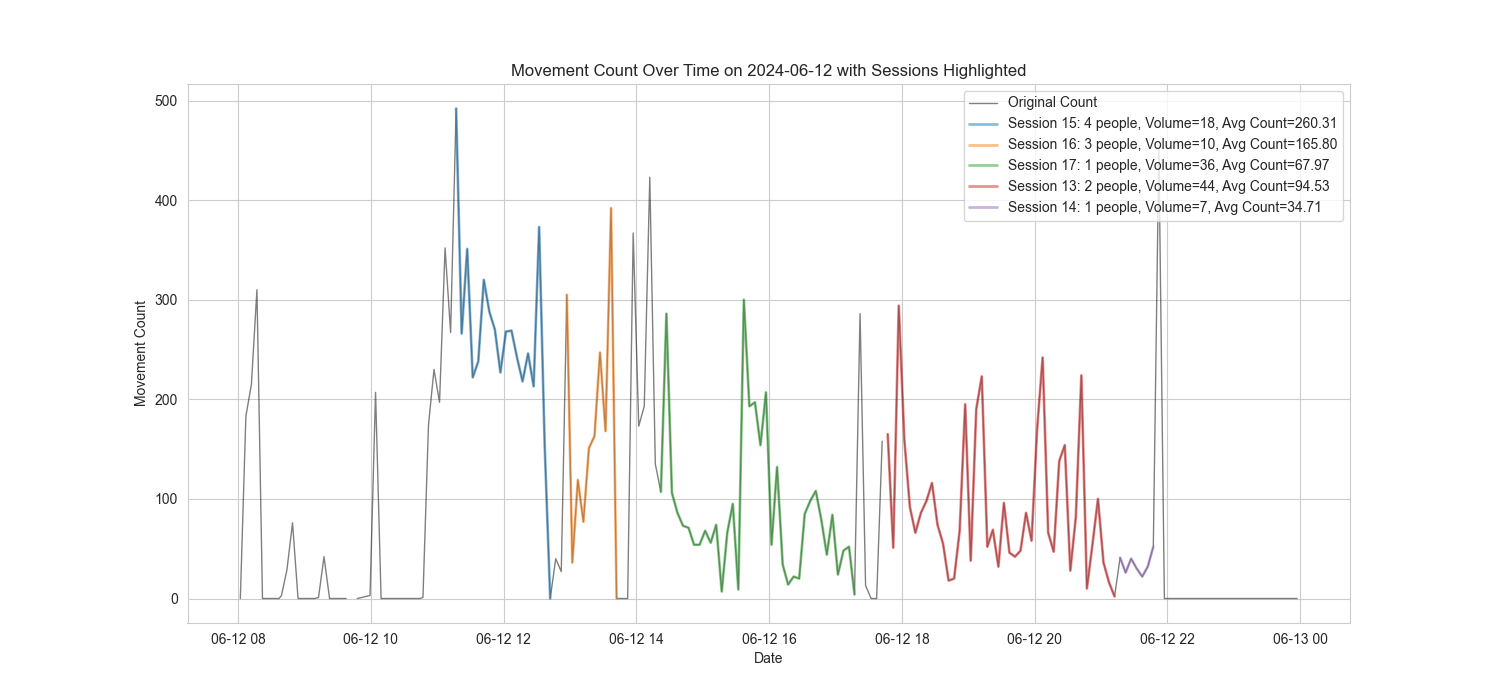

In [28]:
from IPython.display import Image, display
display(Image(data=img))